# Loading Datasets

In [1]:
import  pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from glob import glob
from keras.models import Sequential
from keras.layers import BatchNormalization,MaxPool2D,Dense,Conv2D,Flatten
from keras.callbacks import EarlyStopping,LearningRateScheduler
import warnings
from tqdm import tqdm
from PIL import Image
warnings.filterwarnings('ignore')

In [2]:
df=pd.DataFrame(columns=['image','label'])

In [3]:
# for a picture containing image of vehicle label is 1.

idx=0
for name in tqdm(glob('Dataset/vehicles/*')):
    image=Image.open(name)
    img_seq=image.getdata()
    img=np.array(img_seq)
    img=np.reshape(img,(64,64,3))
    data=pd.DataFrame({'image':[img],'label':[1]},index=[idx])
    df=df.append(data)    
    idx+=1

100%|██████████████████████████████████████████████████████████████████████████████| 8792/8792 [03:06<00:00, 47.04it/s]


In [4]:
# for a picture doesn't contain image of vehicle label is 0.

for name in tqdm(glob('Dataset/non-vehicles/*')):
    image=Image.open(name)
    img_seq=image.getdata()
    img=np.array(img_seq)
    img=np.reshape(img,(64,64,3))
    data=pd.DataFrame({'image':[img],'label':[0]},index=[idx]) 
    df=df.append(data)
    idx+=1

100%|██████████████████████████████████████████████████████████████████████████████| 8968/8968 [03:43<00:00, 40.18it/s]


# Train test spliting of data

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split
split=StratifiedShuffleSplit(n_splits=1,test_size=0.15,random_state=42)
for train_index,test_index in split.split(df,df['label']):
    train_data=df.iloc[train_index]
    test_data=df.iloc[test_index]
# train_x,test_x,train_y,test_y=train_test_split(df['image'],df['label'],random_state=42,test_size=0.15)

In [6]:
train_img,train_label=train_data['image'],train_data['label']
test_img,test_label=test_data['image'],test_data['label']

# Data Visualization

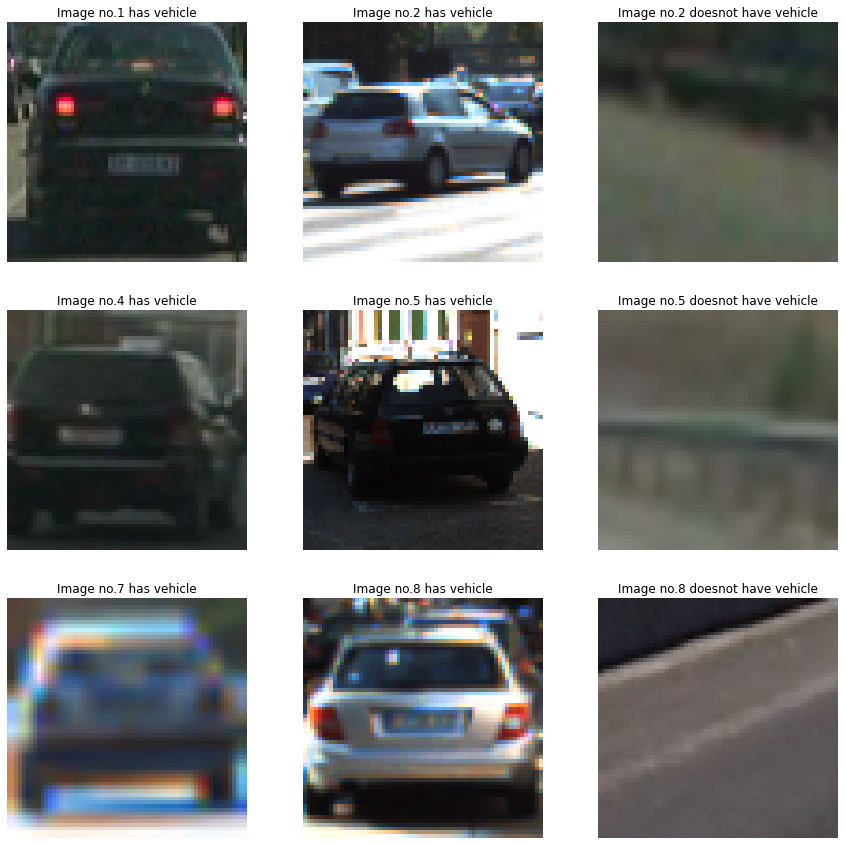

In [7]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,(i%9)+1)
    ix=np.random.randint(3000)
    if(train_label.iloc[ix]==1):
        plt.title('Image no.{0} has vehicle'.format(i+1))
    elif(train_label.iloc[ix]==0):
        plt.title('Image no.{0} doesnot have vehicle'.format(i))
    plt.axis('off')
    plt.imshow(train_img.iloc[ix])
plt.show()

# Changing Dimension Of Data

In [8]:
def change_image_dimension(data):
    data=np.reshape(data.to_list(),(len(data),64,64,3))
    return data

In [9]:
train_img=change_image_dimension(train_img)
test_img=change_image_dimension(test_img)
# train_img
train_img=train_img/255.0
test_img=test_img/255.0

In [10]:
train_label=np.array(train_label,dtype=int)
test_label=np.array(test_label,dtype=int)

# Callback Functions

In [11]:
def schedule(epoch,lr):
    if epoch>=5:
        return 0.0001
    return 0.001
early_stop=EarlyStopping(monitor='val_accuracy',patience=3)
learning_rate_scheduler=LearningRateScheduler(schedule)

# Convolutional Neural Network

In [12]:
model=Sequential()
model.add(Conv2D(128,(3,3),activation='relu',input_shape=(64,64,3)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
r=model.fit(train_img,train_label,validation_data=(test_img,test_label),epochs=10,batch_size=100,callbacks=[early_stop,learning_rate_scheduler])

Epoch 1/10
151/151 [==============================] - 213s 1s/step - loss: 0.0819 - accuracy: 0.9675 - val_loss: 5.0375 - val_accuracy: 0.5049 - lr: 0.0010
Epoch 2/10
151/151 [==============================] - 202s 1s/step - loss: 0.0323 - accuracy: 0.9885 - val_loss: 3.0491 - val_accuracy: 0.5101 - lr: 0.0010
Epoch 3/10
151/151 [==============================] - 215s 1s/step - loss: 0.0185 - accuracy: 0.9934 - val_loss: 2.9198 - val_accuracy: 0.5548 - lr: 0.0010
Epoch 4/10
151/151 [==============================] - 210s 1s/step - loss: 0.0123 - accuracy: 0.9959 - val_loss: 0.7805 - val_accuracy: 0.8243 - lr: 0.0010
Epoch 5/10
151/151 [==============================] - 171s 1s/step - loss: 0.0095 - accuracy: 0.9968 - val_loss: 0.0444 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 6/10
151/151 [==============================] - 167s 1s/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.0076 - val_accuracy: 0.9970 - lr: 1.0000e-04
Epoch 7/10
151/151 [==============================] - 167s 1

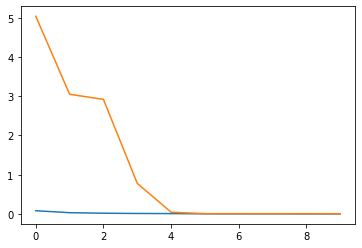

In [15]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

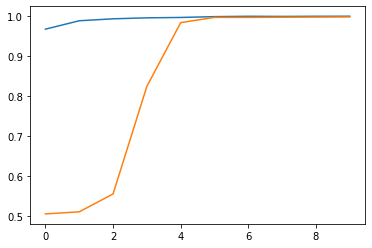

In [16]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])

# Visualization of Predicted Data

1/1 [==============================] - 0s 40ms/step


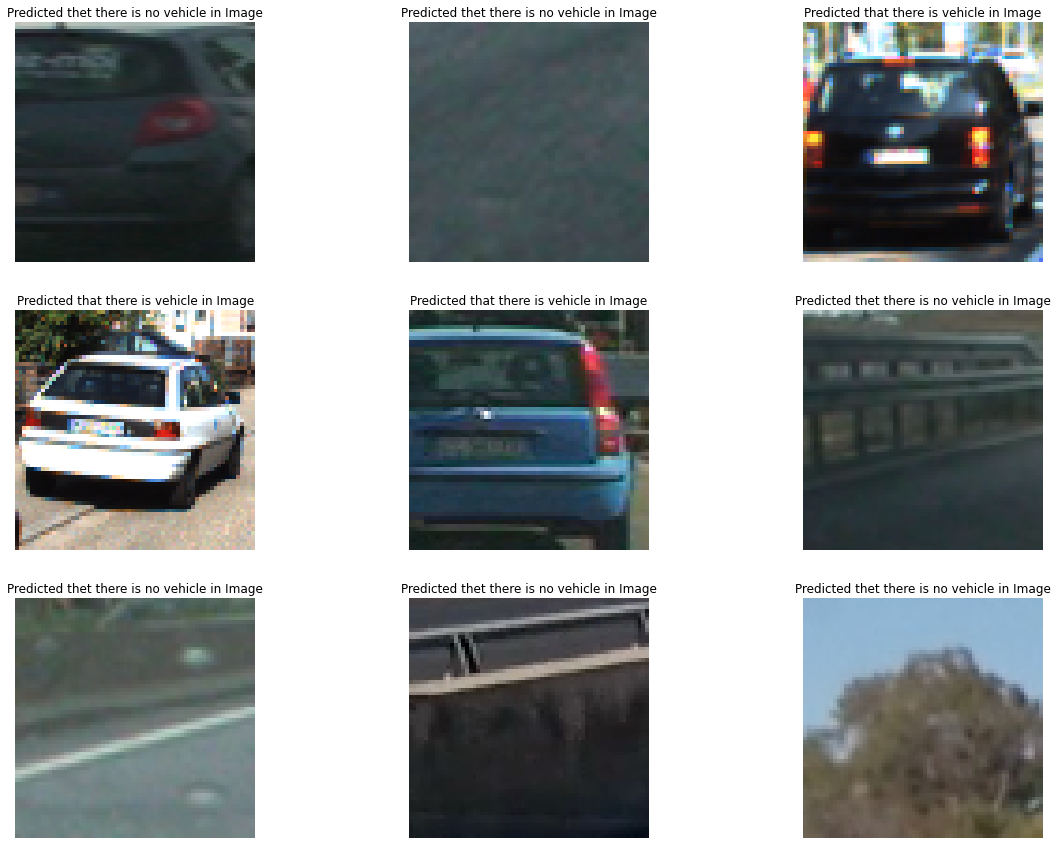

In [21]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(3,3,(i%9)+1)
    rd_idx=np.random.randint(700)
    predict_x=model.predict(np.reshape(test_img[rd_idx],(-1,64,64,3)))
    classes_x=np.argmax(predict_x,axis=1)
    if predict_x==1:
        plt.title('Predicted that there is vehicle in Image')
    else:
        plt.title('Predicted thet there is no vehicle in Image')
    plt.axis('off')
    plt.imshow(test_img[rd_idx])
plt.show()